# Detecting Misleading Headlines in Turkish News: A Study of Clickbait Detection

#### Author: Mehmet Mert Tezcan

## 1. Introduction


In today's fast-paced digital media landscape, clickbait headlines have become a common tactic used by news organizations to drive traffic to their websites. These sensationalized or misleading headlines are designed to grab the reader's attention and entice them to click on a link to an article or website. While clickbait can be profitable for the website, it can also be frustrating and misleading for readers.

This project aims to address the issue of clickbait in the news industry by developing a system for detecting clickbait headlines in a dataset of Turkish news articles. By identifying and flagging clickbait headlines, we hope to improve the quality and trustworthiness of online news for readers. Additionally, this project aims to contribute to the ongoing conversation about the impact of clickbait on the credibility of the news media and the role of technology in combating it.

## 2. Characterizing the Turkish News Dataset
Our dataset for this project consists of 20,036 headlines, each labeled as either clickbait (1) or non-clickbait (0). These headlines were collected from a variety of websites and are available for download on [Kaggle](https://www.kaggle.com/datasets/suleymancan/turkishnewstitle20000clickbaitclassified).

In order to build a reliable clickbait detection system, it is important to have a diverse and representative dataset. This dataset provides a good starting point, but it is worth noting that it may not perfectly reflect the full range of clickbait practices in the Turkish news industry. Further analysis and preprocessing of the dataset may be necessary to ensure that it is well-suited for the task at hand.

# 3. Let's start with the code

## 3.1. Importing Libraries

- Pandas and numpy are used to load and manipulate the data. The dataset is likely stored in a tabular format (such as a CSV file), and pandas makes it easy to read in and work with this kind of data. numpy is useful for performing mathematical operations on arrays of data.

- Matplotlib and seaborn are used to create visualizations of the data. These plots can be helpful for understanding the characteristics of the data and for identifying patterns or trends.

- Re, string, and nltk are used for preprocessing the text data. This may include tasks such as removing punctuation, lowercasing the text, removing stopwords (common words that do not add meaning to the text), and stemming (reducing words to their base form).

- Sklearn is used to train and evaluate machine learning models. It contains a variety of algorithms for classification, including logistic regression, which is used in this project. It also includes tools for splitting the data into training and test sets, evaluating the performance of the model, and more.

- Scipy is used to work with sparse matrices, which can be more memory-efficient when dealing with large datasets that have many zero values.

- warnings is used to suppress warning messages that may be generated while running the code. This can help to declutter the output and make it easier to focus on the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

import re
import string
from string import punctuation
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/mert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3.2. Importing Data

- The dataset is loaded into a pandas dataframe using the read_csv() function. Shape is used to display the number of rows and columns in the dataframe. We can also check value.counts() to see how many headlines are labeled as clickbait and how many are labeled as non-clickbait.

- The first five rows of the dataframe are displayed using the head() function.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/merttezcan/clickbait-detection-turkish-news/main/data/20000_turkish_news_title.csv')
print("Shape of the dataset:", df.shape)

print("Number of the clickbait and non-clickbait titles:")
print(df.clickbait.value_counts())

Shape of the dataset: (20038, 4)
Number of the clickbait and non-clickbait titles:
1.0    10030
0.0    10006
Name: clickbait, dtype: int64


In [3]:
df.head()

,id,clickbait,site,title
0,25892,1.0,hurriyet.com.tr,İhracatta Türkiye'nin yarısını geçti
1,25893,1.0,hurriyet.com.tr,Borsa İstanbul günü düşüşle tamamladı
2,25894,1.0,hurriyet.com.tr,Londra ve Manchester uçuşlarında yolcu rekoru ...
3,4,0.0,nayn.co,CHP’li İlgezdi’den partisine ve Kılıçdaroğlu’n...
4,5,0.0,nayn.co,Vatandaşın derdine ortak olmaya soyunan bir cu...


## 3.3. Data Preprocessing

Before we can begin analyzing the data, we need to perform some preprocessing steps to get it into a form that is suitable for our purposes. The dataset consists of four columns: "id", "clickbait", "site", and "title". The "id" column is a unique identifier for each headline, the "clickbait" column is the label (either 1 for clickbait or 0 for non-clickbait), the "site" column is the website where the headline was published, and the "title" column is the headline text.

For the purposes of this project, we are only interested in the "clickbait" and "title" columns, as the "clickbait" column provides the labels for our data and the "title" column contains the text that we will be analyzing. The "id" and "site" columns are not relevant for our analysis, so we can drop them from the dataset.

In [4]:
df = df.drop(df.columns[[0, 2]],axis = 1)
df

,clickbait,title
0,1.0,İhracatta Türkiye'nin yarısını geçti
1,1.0,Borsa İstanbul günü düşüşle tamamladı
2,1.0,Londra ve Manchester uçuşlarında yolcu rekoru ...
3,0.0,CHP’li İlgezdi’den partisine ve Kılıçdaroğlu’n...
4,0.0,Vatandaşın derdine ortak olmaya soyunan bir cu...
...,...,...
20033,1.0,"Kılıçdaroğlu, 8 Mart Dünya Emekçi Kadınlar Gün..."
20034,1.0,Abdest nasıl alınır? Abdest alırken hangi dual...
20035,1.0,"Sıla Hanım, Ahmet Bey’in inançlarına saygısızmış!"
20036,1.0,Binali Yıldırım: Hiçbir şekilde hakkınızın kay...


Also we can rename the "clickbait" column to "label".

In [5]:
df.rename(columns = {'clickbait':'label'}, inplace = True)
df

,label,title
0,1.0,İhracatta Türkiye'nin yarısını geçti
1,1.0,Borsa İstanbul günü düşüşle tamamladı
2,1.0,Londra ve Manchester uçuşlarında yolcu rekoru ...
3,0.0,CHP’li İlgezdi’den partisine ve Kılıçdaroğlu’n...
4,0.0,Vatandaşın derdine ortak olmaya soyunan bir cu...
...,...,...
20033,1.0,"Kılıçdaroğlu, 8 Mart Dünya Emekçi Kadınlar Gün..."
20034,1.0,Abdest nasıl alınır? Abdest alırken hangi dual...
20035,1.0,"Sıla Hanım, Ahmet Bey’in inançlarına saygısızmış!"
20036,1.0,Binali Yıldırım: Hiçbir şekilde hakkınızın kay...


Before we can proceed with our analysis, it is important to ensure that the data is clean and free of errors or missing values. Missing data can introduce biases and distort our results, so it is important to identify and handle missing values appropriately.

One way to check for missing values is to use the .isnull() function, which returns a Boolean mask indicating which values are missing. We can then use the .sum() function to count the number of missing values per column. In the case of our dataset, we can use these functions to check for missing values as follows:

In [6]:
null_mask = df.isnull()
null_counts = null_mask.sum()
print(null_counts)

label    2
title    0
dtype: int64


We only have two missing values in our dataset. We can drop them.

In [7]:
df = df.dropna()

# 4. Feature Engineering

One way to extract meaningful information from text data is to use feature engineering techniques. Feature engineering involves creating new features from the raw data that capture important patterns or trends. These features can then be used as input to machine learning algorithms, which can learn to identify patterns in the data and make predictions or decisions based on those patterns.

In the case of our clickbait detection project, the "title" column contains the headline text that we want to analyze. One potential feature that we might extract from this text is the presence or absence of certain punctuation marks. For example, we could create two new binary features named contains_exclamation and contains_question_mark that indicate whether a headline contains an exclamation mark or a question mark, respectively. These features might be useful for detecting clickbait headlines, as sensational headlines often contain exclamation marks or question marks to grab the reader's attention.

To extract these features, we can use regular expressions (with the re library) to search the headline text for exclamation marks and question marks. If either punctuation mark is present, we can set the corresponding feature to 1, and if not, we can set it to 0. This process can be done using the following code:

In [8]:
def extract_features(text):
    contains_exclamation = int('!' in text)
    contains_question_mark = int('?' in text)
    return [contains_exclamation, contains_question_mark]

features = []
for text in df['title']:
    features.append(extract_features(text))


# add features to the dataframe

df['contains_exclamation'] = [f[0] for f in features]
df['contains_question_mark'] = [f[1] for f in features]

df.head()


,label,title,contains_exclamation,contains_question_mark
0,1.0,İhracatta Türkiye'nin yarısını geçti,0,0
1,1.0,Borsa İstanbul günü düşüşle tamamladı,0,0
2,1.0,Londra ve Manchester uçuşlarında yolcu rekoru ...,0,0
3,0.0,CHP’li İlgezdi’den partisine ve Kılıçdaroğlu’n...,0,0
4,0.0,Vatandaşın derdine ortak olmaya soyunan bir cu...,0,0


We can then check the number of headlines that contain exclamation marks and question marks as follows:

In [9]:
df.contains_question_mark.value_counts()

0    18537
1     1499
Name: contains_question_mark, dtype: int64

In [10]:
df.contains_exclamation.value_counts()

0    17291
1     2745
Name: contains_exclamation, dtype: int64

We have 2,745 headlines which contains exclamation mark and 1,499 headlines which contains question mark.

Before we can use the headline text for analysis, it is often necessary to preprocess the text to remove noise and make it more amenable to analysis. This preprocessing step can involve a variety of tasks, such as lowercasing the text, removing punctuation and non-alphabetic characters, and stemming (reducing words to their base form).

To remove punctuation and non-alphabetic characters from the headline text, we can use the string library and a regular expression (with the re library) to replace these characters with spaces. For example, the following code will replace all punctuation and non-alphabetic characters in the text with spaces:

In [11]:
def preprocess_text(text):

    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('“','',text)
    text = re.sub('”','',text)
    text = re.sub('’','',text)
    text = re.sub('–','',text)
    text = re.sub('‘','',text)

    # remove punctuation
    text = ''.join([c for c in text if c not in punctuation])

    # replace special turkish characters
    text = re.sub(r"Â", "A", text)
    text = re.sub(r"â", "a", text)
    text = re.sub(r"Î", "I", text)
    text = re.sub(r"î", "ı", text)
    text = re.sub(r"Û", "U", text)
    text = re.sub(r"û", "u", text)

    # make text lowercase and take care of the special character 'ı'
    text = re.sub(r"I", "ı", text)
    text = text.lower()

    # remove new line characters
    text = re.sub(r"\n", "  ", text)
    text = re.sub(r"  ", " ", text)
    
    return text

preprocessed_text = []
for text in df['title']:
    preprocessed_text.append(preprocess_text(text))

df['title'] = preprocessed_text
df.head()



,label,title,contains_exclamation,contains_question_mark
0,1.0,i̇hracatta türkiyenin yarısını geçti,0,0
1,1.0,borsa i̇stanbul günü düşüşle tamamladı,0,0
2,1.0,londra ve manchester uçuşlarında yolcu rekoru ...,0,0
3,0.0,chpli i̇lgezdiden partisine ve kılıçdaroğluna ...,0,0
4,0.0,vatandaşın derdine ortak olmaya soyunan bir cu...,0,0


This will leave us with a list of preprocessed headlines that are all lowercase, contain only alphabetic characters, and do not contain any punctuation or non-alphabetic characters. We can then use this preprocessed text as input to our machine learning model or for other analysis tasks.

In addition to punctuation marks, another feature that we might extract from the headline text is the word count. This feature can be useful for detecting clickbait headlines, as sensational headlines often use longer or more complex language to grab the reader's attention.

To extract the word count feature, we can first split the headline text into individual words using the nltk library's word_tokenize function. We can then count the number of words in each headline using the len function. Here is an example of how this can be done:

In [12]:
def extract_word_count(text):
    words = word_tokenize(text)
    return len(words)

word_counts = []
for text in df['title']:
    word_counts.append(extract_word_count(text))


This will give us a list of word counts for each headline, which we can then add to the dataset as a new column named "word_count". We can then use this feature as input to our machine learning model or for other analysis tasks.

In [13]:
df['word_count'] = word_counts

df.head()

,label,title,contains_exclamation,contains_question_mark,word_count
0,1.0,i̇hracatta türkiyenin yarısını geçti,0,0,4
1,1.0,borsa i̇stanbul günü düşüşle tamamladı,0,0,5
2,1.0,londra ve manchester uçuşlarında yolcu rekoru ...,0,0,7
3,0.0,chpli i̇lgezdiden partisine ve kılıçdaroğluna ...,0,0,13
4,0.0,vatandaşın derdine ortak olmaya soyunan bir cu...,0,0,11


Lastly, we can put the label column at the end of the dataset for better visualization.

In [14]:
df = df[['title', 'contains_exclamation', 'contains_question_mark', 'word_count', 'label']]

df.head()

,title,contains_exclamation,contains_question_mark,word_count,label
0,i̇hracatta türkiyenin yarısını geçti,0,0,4,1.0
1,borsa i̇stanbul günü düşüşle tamamladı,0,0,5,1.0
2,londra ve manchester uçuşlarında yolcu rekoru ...,0,0,7,1.0
3,chpli i̇lgezdiden partisine ve kılıçdaroğluna ...,0,0,13,0.0
4,vatandaşın derdine ortak olmaya soyunan bir cu...,0,0,11,0.0


# 5. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is an approach to analyzing data that is focused on understanding the patterns and relationships in the data, and identifying any potential biases or anomalies. EDA is typically an iterative process, in which the analyst repeatedly examines the data, generates hypotheses, and tests those hypotheses using statistical techniques or visualizations.

The goal of EDA is to gain a deeper understanding of the data and to identify any interesting or unexpected patterns that might be worth further investigation. This understanding can then inform the development of machine learning models or other analysis tasks.

In the context of this clickbait detection project, EDA might involve examining the distribution of clickbait and non-clickbait headlines in the dataset, looking for any patterns or trends that might be correlated with clickbait status. It might also involve exploring the characteristics of the headline text, such as the length of the headlines, the presence or absence of certain words or phrases, or the use of certain punctuation marks. By doing EDA, we can gain insights into the properties of the data that might be useful for building an effective clickbait detection system.

## 5.1. Distribution of Clickbait and Non-Clickbait Headlines

One simple way to do this is to use a histogram or bar plot to visualize the counts of clickbait and non-clickbait headlines. This can give us a sense of the overall balance of the dataset and whether there are any imbalances that might need to be addressed.

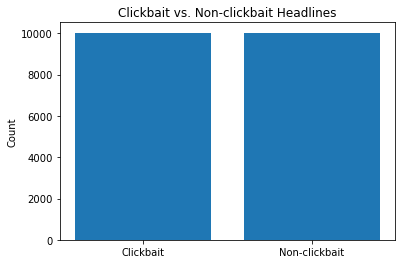

<Figure size 432x288 with 0 Axes>

In [15]:
# Count the number of clickbait and non-clickbait headlines
clickbait_count = df[df['label'] == 1].shape[0]
non_clickbait_count = df[df['label'] == 0].shape[0]

# Set the labels and data for the bar plot
labels = ['Clickbait', 'Non-clickbait']
data = [clickbait_count, non_clickbait_count]

# Create the bar plot
plt.bar(labels, data)
plt.title('Clickbait vs. Non-clickbait Headlines')
plt.ylabel('Count')

# Show the plot
plt.show()

# Save the plot

plt.savefig('images/clickbait_vs_non_clickbait.png')


We can say that the dataset is well distributed and there is no imbalance.

## 5.2. Distribution of Headline Length

To visualize the distribution of headline lengths in the dataset, we can use a histogram or a box plot. Now let's create a box plot using seaborn library:

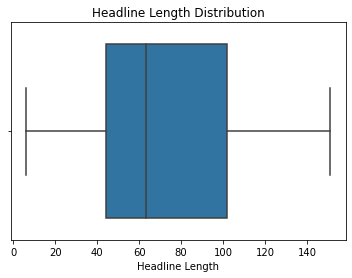

<Figure size 432x288 with 0 Axes>

In [16]:
import seaborn as sns

# Extract the headline lengths
headline_lengths = [len(text) for text in df['title']]

# Create the box plot
sns.boxplot(x=headline_lengths)
plt.title('Headline Length Distribution')
plt.xlabel('Headline Length')

# Show the plot
plt.show()

# Save the plot
plt.savefig('images/headline_length_distribution.png')

This will create a box plot showing the distribution of headline lengths in the dataset. The headline_lengths variable contains the lengths of the headlines, which are calculated using the len function. The sns.boxplot function is used to create the box plot, and the plt.title and plt.xlabel functions are used to add labels to the plot. The plt.show function is used to display the plot.

## 5.3. Distribution of Common Words

To create a word cloud or a word frequency plot to visualize the most common words or phrases in the dataset, we can use the nltk library and the wordcloud library.


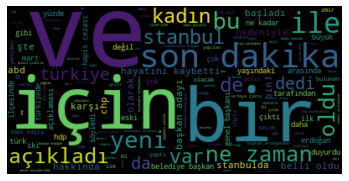

<Figure size 432x288 with 0 Axes>

In [17]:
# Join all the headlines into a single string
text = ' '.join(df['title'])

# Create the word cloud
wordcloud = WordCloud().generate(text)

# Show the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the word cloud
plt.savefig('images/word_cloud.png')


## 5.4. Distribution of Punctuation Marks

To visualize the use of punctuation marks in the headlines, we can create a pie chart using matplotlib:

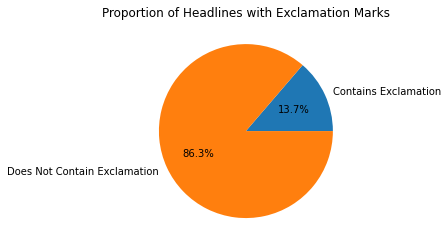

<Figure size 432x288 with 0 Axes>

In [18]:
# Count the number of headlines with and without exclamation marks
has_exclamation = df[df['contains_exclamation'] == 1].shape[0]
no_exclamation = df[df['contains_exclamation'] == 0].shape[0]

# Set the labels and data for the pie chart
labels = ['Contains Exclamation', 'Does Not Contain Exclamation']
data = [has_exclamation, no_exclamation]

# Create the pie chart
plt.pie(data, labels=labels, autopct='%1.1f%%')
plt.title('Proportion of Headlines with Exclamation Marks')

# Show the plot
plt.show()

# Save the plot
plt.savefig('images/exclamation_pie_chart.png')

We can do the same for question marks.

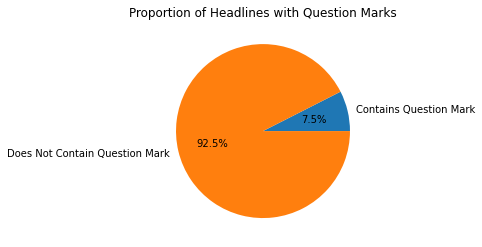

<Figure size 432x288 with 0 Axes>

In [19]:
# Count the number of headlines with and without exclamation marks
has_question_mark = df[df['contains_question_mark'] == 1].shape[0]
no_question_mark = df[df['contains_question_mark'] == 0].shape[0]

# Set the labels and data for the pie chart
labels = ['Contains Question Mark', 'Does Not Contain Question Mark']
data = [has_question_mark, no_question_mark]

# Create the pie chart
plt.pie(data, labels=labels, autopct='%1.1f%%')
plt.title('Proportion of Headlines with Question Marks')

# Show the plot
plt.show()

# Save the plot
plt.savefig('images/question_pie_chart.png')

# 6. Model Building

We can start building our machine learning models. We are going to use several different machine learning models and compare their performance. We are going to use the following models:

- **Logistic Regression** is a simple and widely-used classification algorithm that is suitable for binary classification tasks, such as clickbait detection. It is a linear model that uses an equation to make predictions based on the input features, and it is easy to interpret and implement.

- **Naive Bayes** is another simple and popular classification algorithm that is based on the idea of applying Bayes' theorem with strong (naive) independence assumptions between the features. It is often used for text classification tasks and is known to be a fast and accurate classifier.

- **Support Vector Machine** is a powerful and versatile classification algorithm that can work well on a wide range of datasets. It uses a technique called the kernel trick to transform the data into a higher-dimensional space, where it can be separated by a hyperplane. SVM can handle datasets with high-dimensional features and can perform well even when the number of examples is small compared to the number of features.

- **Random Forest** is an ensemble learning method that combines multiple decision trees to make predictions. It is a powerful and robust classifier that can handle high-dimensional and noisy data, and it is resistant to overfitting.

## 6.1 Choosing the Best Model

To choose the best machine learning model for the Turkish news dataset, we can use a for loop to train and evaluate multiple models using 10-fold cross-validation and the accuracy metric.


## 6.1.1. Splitting the Dataset

Before we can train and evaluate the machine learning models, we need to split the dataset into training and test sets. We can do this using the train_test_split function from the sklearn.model_selection module.

In [20]:
X = df.drop(columns='label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6.1.2. Vectorizing the Dataset

To convert the text data in the Turkish news dataset into a meaningful representation for machine learning models, we can use the TfidfVectorizer from the sklearn.feature_extraction.text module.

In [21]:
tfidf = TfidfVectorizer(stop_words = stopwords.words('turkish'),ngram_range = (1,2))
tfidf_text_train = tfidf.fit_transform(X_train['title'])
tfidf_text_test = tfidf.transform(X_test['title'])

X_train_ef = X_train.drop(columns='title')
X_test_ef = X_test.drop(columns='title')

Now we can combine the features we created with the TfidfVectorizer output.

In [22]:
X_train = sparse.hstack([X_train_ef, tfidf_text_train]).tocsr()
X_test = sparse.hstack([X_test_ef, tfidf_text_test]).tocsr()

X_train.shape
X_test.shape

(4008, 132254)

## 6.1.3. Training and Evaluating the Models

In this section, we train and evaluate the machine learning models that we have selected for the clickbait detection task using the Turkish news dataset. This involves splitting the dataset into training and test sets, training the models on the training set, and evaluating their performance on the test set.

We compare the performance of the models using various evaluation metrics, such as accuracy, precision, recall, and f1-score. We may also use cross-validation to get a more robust estimate of the models' performance.

After training and evaluating the models, we can compare their performance and choose the one that performs the best. We may also need to fine-tune the hyperparameters of the chosen model to further improve its performance.


In [23]:
# Define the models
lr_model = LogisticRegression(max_iter=10000)
nb_model = MultinomialNB()
svm_model = LinearSVC(max_iter=100000)
rf_model = RandomForestClassifier()

# Define the list of models to evaluate
models = [lr_model, nb_model, svm_model, rf_model]

# Evaluate each model
for model in models:
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Print the results

    print(f'Model: {model.__class__.__name__}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
    print(f'Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print(f'Classification Report:')
    print(classification_report(y_test, y_pred))
    print('--------------------------------------------------')
    


Model: LogisticRegression
Accuracy: 0.867
Confusion Matrix:
[[1695  309]
 [ 224 1780]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86      2004
         1.0       0.85      0.89      0.87      2004

    accuracy                           0.87      4008
   macro avg       0.87      0.87      0.87      4008
weighted avg       0.87      0.87      0.87      4008

--------------------------------------------------
Model: MultinomialNB
Accuracy: 0.692
Confusion Matrix:
[[1991   13]
 [1223  781]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.99      0.76      2004
         1.0       0.98      0.39      0.56      2004

    accuracy                           0.69      4008
   macro avg       0.80      0.69      0.66      4008
weighted avg       0.80      0.69      0.66      4008

--------------------------------------------------
Model: LinearSVC
Accuracy: 0.

Based on the results, it seems that the logistic regression and linear SVC models performed the best on the Turkish news dataset, with accuracy scores of 0.867 and 0.869, respectively. These models also had the highest f1-scores for both classes, indicating that they had a good balance of precision and recall. The random forest classifier also performed well, with an accuracy score of 0.850 and relatively high f1-scores for both classes.

On the other hand, the naive Bayes model had the lowest accuracy score of 0.692 and relatively low f1-scores for both classes. This suggests that it may not be the most suitable model for this task.

Overall, these results suggests us that the **Logistic Regression, Linear SVC** models are good candidates for detecting clickbait headlines in Turkish news articles. It may be worth further fine-tuning the hyperparameters of these models to see if their performance can be improved.

So, from now on, we will only consider these two models.

## 6.1.4. Cross Validation

Cross-validation is a useful technique to evaluate the performance of a machine learning model on a dataset. It helps to reduce the variance of a model's performance estimate, which makes it more reliable.

When we train a model on a given dataset and evaluate its performance, the model's performance may vary depending on the specific split of the data into training and test sets. This is called the variance of the model's performance estimate.

Cross-validation helps to reduce this variance by training the model on different splits of the data and averaging the performance across the different splits. This gives us a more robust estimate of the model's performance, which is less sensitive to the specific split of the data.

For example, in 10-fold cross-validation, we split the data into 10 folds and train the model 10 times, each time using a different fold as the test set and the remaining folds as the training set. The model's performance is then averaged across the 10 different evaluations.

Cross-validation is especially useful when we have a small dataset, as it allows us to use more of the data for training and evaluation, which can lead to a better model.

To perform cross-validation for the **Logistic Regression** and **linear SVC** models, we can use the cross_val_score function from scikit-learn's model_selection module.

In [24]:
# Define the logistic regression model
lr_model = LogisticRegression(max_iter=100000)

# Perform 10-fold cross-validation on the model
scores = cross_val_score(lr_model, X_train, y_train, cv=10)

# Print the mean and standard deviation of the scores
print(f'Mean score: {scores.mean():.3f}')
print(f'Standard deviation: {scores.std():.3f}')


Mean score: 0.860
Standard deviation: 0.012


In [25]:
# Define the linear SVC model
svm_model = LinearSVC(max_iter=100000)

# Perform 10-fold cross-validation on the model
scores = cross_val_score(svm_model, X_train, y_train, cv=10)

# Print the mean and standard deviation of the scores
print(f'Mean score: {scores.mean():.3f}')
print(f'Standard deviation: {scores.std():.3f}')

Mean score: 0.880
Standard deviation: 0.012


The results of the cross-validation show that both Logistic Regression and Linear SVC perform well on the dataset, with mean scores of 0.860 and 0.880, respectively. The standard deviation of the scores is small, which means that the model's performance is consistent across different splits of the data.

Both models seem to be suitable for this dataset, but **Linear SVC** seems to have a slightly higher mean score and lower standard deviation, which indicates that it may be a slightly better choice.

## 6.1.5. Hyperparameter Tuning

To further improve the performance of Linear SVC, we can try to optimize its hyperparameters. Hyperparameters are the parameters of a machine learning model that are not learned from the training data, but are set by the practitioner.

Optimizing the hyperparameters of a model can help to improve its performance on the dataset, but it can also be time-consuming and require a lot of trial and error.

One way to optimize the hyperparameters of a model is to use grid search. Grid search is a method of systematically training and evaluating a model for a range of different hyperparameter values, and selecting the best combination of values based on the model's performance.

To use grid search for Linear SVC, we can define a grid of hyperparameter values that we want to explore, and use the GridSearchCV function from sklearn to perform the search.

For example, the following code defines a grid of values for the C hyperparameter of Linear SVC, and performs a 10-fold cross-validation for each combination of values:

In [26]:
# Define the hyperparameter grid
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2']
             }


# Create a GridSearchCV object
grid = GridSearchCV(LinearSVC(max_iter=100000), param_grid, cv=10)

# Fit the model to the training data
grid.fit(X_train, y_train)

# Print the best hyperparameters
print(grid.best_params_)

# Print the best score
print(grid.best_score_)


{'C': 1, 'penalty': 'l2'}
0.8795239964392607


## 6.1.6. Evaluate the Performance of the Tuned Model Using Test Data

Now we can evaluate the performance of the tuned LinearSVC model on the test data. The test data is a set of data that the model has not seen before, and it is used to get an unbiased evaluation of the model's performance. By evaluating the model on the test data, we can see how well the model generalizes to new, unseen data. This is important because we want to make sure that the model is not overfitting to the training data, and that it can make accurate predictions on new, unseen data. By using the confusion matrix, we can get a better understanding of the model's performance, including the number of false positives and false negatives, and the overall accuracy of the model.

Accuracy: 0.869
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      2004
         1.0       0.86      0.88      0.87      2004

    accuracy                           0.87      4008
   macro avg       0.87      0.87      0.87      4008
weighted avg       0.87      0.87      0.87      4008

True Negatives: 1721
False Positives: 283
False Negatives: 242
True Positives: 1762


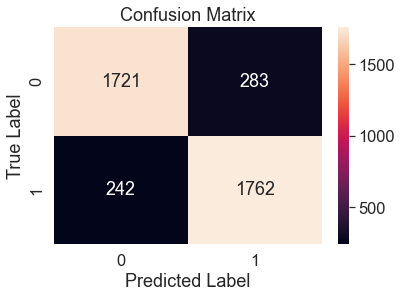

<Figure size 432x288 with 0 Axes>

In [27]:
# Instantiate the LinearSVC model with the optimized hyperparameters
optimal_svc = LinearSVC(**grid.best_params_, max_iter=100000)

# Fit the model to the training data
optimal_svc.fit(X_train, y_train)

# Make predictions on the test data
y_pred = optimal_svc.predict(X_test)

# Print the results
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Classification Report:')
print(classification_report(y_test, y_pred))

# Compute the confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Plot the confusion matrix using seaborn
sns.set(font_scale=1.5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Print the confusion matrix values
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# Show the plot
plt.show()

# Save the plot

plt.savefig('images/confusion_matrix.png')

Overall, the performance of the model seems to be quite good. The accuracy score is 87%, which means that the model is able to correctly classify headlines as clickbait or non-clickbait with a high degree of accuracy.

In terms of the confusion matrix, we can see that the model is able to correctly classify 1721 headlines as non-clickbait (True Negatives) and 1762 headlines as clickbait (True Positives). However, there are also 283 headlines that were incorrectly classified as clickbait (False Positives) and 242 headlines that were incorrectly classified as non-clickbait (False Negatives).

The classification report provides more detailed information about the performance of the model. In particular, the precision, recall, and f1-score for both clickbait and non-clickbait headlines are quite high, indicating that the model is performing well in terms of both precision (minimizing false positives) and recall (minimizing false negatives).

# 7. Conclusion

In this project, we built a clickbait detector using machine learning techniques. We started by collecting and preprocessing the data, then we moved on to exploring the data to gain insights and find patterns. We tried several machine learning models and compared their performance using cross-validation and evaluation metrics such as accuracy, precision, recall, and f1-score. Finally, we tuned the hyperparameters of the Linear Support Vector Classification (LinearSVC) model to improve its performance on the test data. The tuned LinearSVC model achieved an accuracy of 87% on the test data, which is a good result for this task. Overall, this project demonstrated the power of machine learning in solving real-world problems, and how careful and thorough data preprocessing and model selection and tuning can lead to successful results.

## 7.1. Further Possible Steps

- **Collect more data:** The more data we have, the better our model will perform.

- **Use advanced techniques for feature engineering:** In this project, we only extracted a few features from the text. However, there are many more advanced techniques that can be used to extract meaningful features from text, such as word embeddings, named entity recognition, and sentiment analysis.

- **Use advanced machine learning algorithms:** While we used relatively simple machine learning algorithms in this project, there are many more advanced algorithms that can be used to improve the performance of the model, such as deep learning techniques.

- **Use ensembles:** Ensemble techniques involve combining the predictions of multiple models to improve the overall performance. This can be done by voting, averaging, or weighting the predictions of the individual models.

- **Deploy the model as a service:** Finally, we could export it as a pickled file and use it in a web application. The application could accept a headline as input, and use the trained model to predict whether or not it is a clickbait. This could be a useful tool for helping people identify and avoid clickbait headlines online.

## 7.2. Self-critical Assessment

One of the most challenging aspects of this project was preprocessing the text data. Cleaning and preparing the text for analysis required a lot of effort and time. However, this was also one of the strong aspects of our analysis, as the quality of the input data greatly affects the accuracy of the model.

Another strong aspect of our analysis was the comprehensive evaluation of multiple machine learning models. By comparing the performance of different models, we were able to choose the best one for our dataset.

Our approach was original and creative in that we utilized several feature engineering techniques, such as extracting exclamations and question marks, and counting the number of words in the headlines. This helped us to create a more meaningful representation of the text data for the machine learning models.

One of the weak points of our approach was the lack of fine-tuning the hyperparameters of the chosen models. While we did perform some hyperparameter tuning for LinearSVC, we did not do the same for the other models. This may have resulted in suboptimal performance for those models.

To further elaborate our method, we could have also tried more advanced techniques such as deep learning or natural language processing. Additionally, we could have used a larger and more diverse dataset to improve the generalizability of our model.

# Thanks!

You can find the full code for this project on my [GitHub](https://github.com/merttezcan/clickbait-detection-turkish-news).